### 0. Questions

 - What are Decision Trees?
 - How to build a tree?
 - What is impurity criterion (quality criterion)?
     - For classification
         - Gini (gini impurity)
         - Entropy (information gain)
     - For regression
 - How a decision tree works with numerical features?
 - What are the main parameters for Decision Tree? 
     - max_depth <!-- the maximum depth of the tree -->
     - max_features <!-- the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for all features) -->
     - min_samples_leaf <!-- the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members. -->
 - How to deal with overfitting in decision trees?
 <!-- artificial limitation of the depth or a minimum number of samples in the leaves: the construction of a tree just stops at some point;
pruning the tree. -->
 - In what situation trees can be built to the maximum depth?
 <!-- 
Random Forest (a group of trees) averages the responses from individual trees that are built to the maximum depth (we will talk later on why you should do this)
Pruning trees. In this approach, the tree is first constructed to the maximum depth. Then, from the bottom up, some nodes of the tree are removed by comparing the quality of the tree with and without that partition (comparison is performed using cross-validation, more on this below). -->
 - What are advantages and disadvantages of decision trees?  
  <!--
Pros:
- Generation of clear human-understandable classification rules, e.g. "if age <25 and is interested in motorcycles, deny the loan". This property is called interpretability of the model.
- Decision trees can be easily visualized, i.e. both the model itself (the tree) and prediction for a certain test object (a path in the tree) can "be interpreted".
- Fast training and forecasting.
- Small number of model parameters.
- Supports both numerical and categorical features.

Cons:
- The trees are very sensitive to the noise in input data; the whole model could change if the training set is slightly modified (e.g. remove a feature, add some objects). This impairs the interpretability of the model.
- Separating border built by a decision tree has its limitations – it consists of hyperplanes perpendicular to one of the coordinate axes, which is inferior in quality to some other methods, in practice.
- We need to avoid overfitting by pruning, setting a minimum number of samples in each leaf, or defining a maximum depth for the tree. Note that overfitting is an issue for all machine learning methods.
- Instability. Small changes to the data can significantly change the decision tree. This problem is tackled with decision tree ensembles (discussed next time).
- The optimal decision tree search problem is NP-complete. Some heuristics are used in practice such as greedy search for a feature with maximum information gain, but it does not guarantee finding the globally optimal tree.
- Difficulties to support missing values in the data. Friedman estimated that it took about 50% of the code to support gaps in data in CART (an improved version of this algorithm is implemented in sklearn).
- The model can only interpolate but not extrapolate (the same is true for random forests and tree boosting). That is, a decision tree makes constant prediction for the objects that lie beyond the bounding box set by the training set in the feature space. In our example with the yellow and blue balls, it would mean that the model gives the same predictions for all balls with positions >19 or <0.
-->


### 1. Import packages

First, let's import needed modules and set random seed (we'll use it if needed).

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

SEED = 42

### 2. Data preparation

#### 2.1 Synthetic data generation

I'm going to use only two features for better visualization and analysis

In [20]:
# first class
np.random.seed(SEED)
train_data = np.random.normal(size=(100, 2), loc=0)
train_labels = np.zeros(100)

In [21]:
# adding second class
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

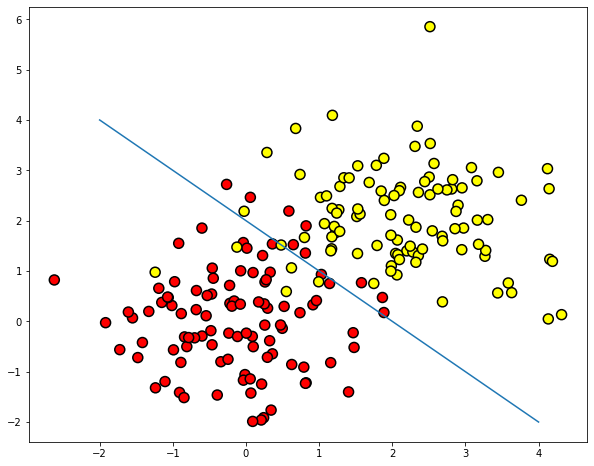

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(
    train_data[:, 0],
    train_data[:, 1],
    c=train_labels,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5,
)
plt.plot(range(-2, 5), range(4, -3, -1))

#### 2.2 Splitting the data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.3, random_state=SEED)

### 3. Predictive modelling

#### 3.1 Sklearn's implementation of Decision Trees Classifier

In [9]:
dt = DecisionTreeClassifier(max_depth=3, random_state=SEED)
dt.fit(X_train, y_train)
pred_sklearn = dt.predict(X_test)

f1_sklearn = f1_score(y_true=y_test, y_pred=pred_sklearn, average='weighted').round(2)
print(f'F1 is equal to {f1_sklearn}')

F1 is equal to 0.9


#### 3.2 Vizualization of separation boundary

In [10]:
# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

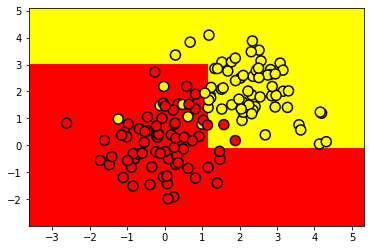

In [11]:
# some code to depict separating surface
xx, yy = get_grid(X_train)
predicted = dt.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap="autumn", shading='auto')
plt.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=100,
    cmap="autumn",
    edgecolors="black",
    linewidth=1.5
)

In [15]:
import pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    """
    This requires GraphViz to be installed.  
    """
    
    tree_str = export_graphviz(
        tree, feature_names=feature_names, filled=True, out_file=None
    )
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [14]:
tree_graph_to_png(
    tree=dt,
    feature_names=['x1', 'x2'],
    png_file_to_save="img/decision_tree1.png",
)

![Decision Tree for Iris dataset](img/decision_tree1.png)

### TODO: 
 - 